<a href="https://colab.research.google.com/github/nuvard/Where-to-eat/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
!git clone https://github.com/nuvard/Where-to-eat.git

path = '/content/Where-to-eat/'

Cloning into 'Where-to-eat'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 11), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [0]:
import pandas as pd
df = pd.read_csv(path+'data/yandex_rests_preprocessed.csv')

In [221]:
df.columns

Index(['lat', 'lng', 'name', 'rating_yandex', 'review_count', 'reviews',
       'discount_10', 'discount_15', 'discount_20', 'discount_50',
       'discount_7', 'Завтраки в ресторане МА', 'Счастливые часы',
       'барная стойка', 'бесплатная парковка', 'бранчи', 'винная карта',
       'детская анимация', 'живая музыка', 'закрытие под банкет',
       'круглосуточная кухня', 'кулинария', 'кухня_авторская',
       'кухня_азербайджанская', 'кухня_азиатская', 'кухня_американская',
       'кухня_английская', 'кухня_армянская', 'кухня_белорусская',
       'кухня_веганская', 'кухня_вегетарианская', 'кухня_восточная',
       'кухня_греческая', 'кухня_грузинская', 'кухня_домашняя',
       'кухня_еврейская', 'кухня_европейская', 'кухня_индийская',
       'кухня_индонезийская', 'кухня_ирландская', 'кухня_испанская',
       'кухня_итальянская', 'кухня_кавказская', 'кухня_китайская',
       'кухня_континентальная', 'кухня_корейская', 'кухня_латиноамериканская',
       'кухня_международная', 'кухня_

In [222]:
df  = df.drop(columns = ['rating_yandex_norm', 'review_count_norm', 'popularity',
       'kitchen', ' DJ', ' барная стойка', ' бесплатная парковка',
       ' винная карта', ' живая музыка', ' закрытие под банкет',
       ' круглосуточная кухня', ' меню на английском',
       ' местоположение у воды', ' настольные игры', ' своя пекарня',
       ' устричный бар', '24_hour', 'DJ',
       "Restopub Finnegan's приглашает на бизнес ланч", 'link'])

KeyError: ignored

In [0]:
df = df.loc[df.lng.isna()==False,]

In [0]:
df.to_csv(path+'data/yandex_rests_preprocessed.csv', index=False)

In [8]:
!pip install h2o
import h2o

h2o.init()


     |████████████████████████████████| 123.7MB 78kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.9-py2.py3-none-any.whl size=123719079 sha256=5d7c7ac64395a45928dea07123cb4aa09fd08ed3f403f2fe53424082b44de66d
  Stored in directory: /root/.cache/pip/wheels/ff/a9/36/487108894572fb92f9262ef16b3db700601992274b9705b214
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd3fhitnt
  JVM stdout: /tmp/tmpd3fhitnt/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpd3fhitnt/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
C

H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_unknownUser_68csv0
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [90]:
fr = h2o.import_file(path=path+'data/yandex_rests_preprocessed.csv')   # import prostate data

from h2o.estimators.gbm import H2OGradientBoostingEstimator  # import gbm estimator



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [164]:
m = H2OGradientBoostingEstimator(ntrees=10, max_depth=5, nfolds = 5, seed = 42)     # setup the gbm

r = fr[0].runif()                       # generate a random vector for splitting

train = fr[ r < 0.7 ]                   # split out 60% for training

test = fr[ 0.7 <= r ]               

m.train(x=fr.names[0:2]+fr.names[5:], y="rating_yandex", training_frame=train \
        )      # train the model

print(m.type)                                       

gbm Model Build progress: |███████████████████████████████████████████████| 100%
regressor


In [165]:
m.mse()

0.0366769490620906

In [166]:
m.model_performance()


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0366769490620906
RMSE: 0.19151226869861523
MAE: 0.12395806250760857
RMSLE: 0.0474138755223173
Mean Residual Deviance: 0.0366769490620906


In [0]:
train_metrics = m.model_performance()

In [0]:
test_metrics = m.model_performance(test_data=test)

In [67]:
test_metrics


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.30641974378948644
RMSE: 0.5535519341394143
MAE: 0.3863122870396907
RMSLE: 0.12150382471873776
Mean Residual Deviance: 0.30641974378948644


In [167]:
m.r2

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1572783297559_10


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,10.0,25446.0,5.0,5.0,5.0,22.0,25.0,23.4




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0366769490620906
RMSE: 0.19151226869861523
MAE: 0.12395806250760857
RMSLE: 0.0474138755223173
Mean Residual Deviance: 0.0366769490620906

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.22428980132484605
RMSE: 0.4735924422167715
MAE: 0.29606973984157187
RMSLE: 0.10435928306254662
Mean Residual Deviance: 0.22428980132484605

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.29578033,0.03312455,0.2976833,0.30308414,0.27549034,0.25739658,0.3452473
1,mean_residual_deviance,0.22361599,0.059131194,0.24460222,0.22967921,0.18008657,0.15609914,0.30761284
2,mse,0.22361599,0.059131194,0.24460222,0.22967921,0.18008657,0.15609914,0.30761284
3,r2,0.120788,0.07629386,0.16802539,0.1349907,0.19494642,0.108472876,-0.002495387
4,residual_deviance,0.22361599,0.059131194,0.24460222,0.22967921,0.18008657,0.15609914,0.30761284
5,rmse,0.46958196,0.062337518,0.49457276,0.47924858,0.4243661,0.39509383,0.55462855
6,rmsle,0.10306022,0.016762309,0.115926854,0.10295643,0.09098531,0.08256311,0.1228694



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2019-11-03 14:11:59,1.542 sec,0.0,0.505775,0.341628,0.255809
1,,2019-11-03 14:11:59,1.574 sec,1.0,0.456718,0.307734,0.208591
2,,2019-11-03 14:11:59,1.598 sec,2.0,0.412680,0.277262,0.170305
3,,2019-11-03 14:11:59,1.623 sec,3.0,0.373199,0.250105,0.139277
4,,2019-11-03 14:11:59,1.644 sec,4.0,0.337780,0.225677,0.114095
5,,2019-11-03 14:11:59,1.669 sec,5.0,0.306009,0.203684,0.093641
6,,2019-11-03 14:11:59,1.692 sec,6.0,0.277655,0.184053,0.077092
7,,2019-11-03 14:11:59,1.715 sec,7.0,0.252230,0.166472,0.063620
8,,2019-11-03 14:11:59,1.743 sec,8.0,0.229612,0.150719,0.052722
9,,2019-11-03 14:11:59,1.770 sec,9.0,0.209460,0.136567,0.043873



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,name,843.741882,1.000000,0.998104
1,lng,1.461385,0.001732,0.001729
2,кухня_итальянская,0.046581,0.000055,0.000055
3,живая музыка,0.027903,0.000033,0.000033
4,своя пекарня,0.025612,0.000030,0.000030
5,барная стойка,0.023311,0.000028,0.000028
6,кухня_авторская,0.011670,0.000014,0.000014
7,кухня_европейская,0.006642,0.000008,0.000008
8,24_hour,0.000000,0.000000,0.000000
9,DJ,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


<bound method ModelBase.r2 of >

In [97]:
test

lng,name,rating_yandex,review_count,закрытие под банкет,24_hour,DJ,discount_10,discount_15,discount_20,discount_50,discount_7,Счастливые часы,барная стойка,бесплатная парковка,бранчи,винная карта,детская анимация,живая музыка,круглосуточная кухня,кулинария,кухня_авторская,кухня_азербайджанская,кухня_азиатская,кухня_американская,кухня_английская,кухня_армянская,кухня_белорусская,кухня_веганская,кухня_вегетарианская,кухня_восточная,кухня_греческая,кухня_грузинская,кухня_домашняя,кухня_еврейская,кухня_европейская,кухня_индийская,кухня_индонезийская,кухня_ирландская,кухня_испанская,кухня_итальянская,кухня_кавказская,кухня_китайская,кухня_континентальная,кухня_корейская,кухня_латиноамериканская,кухня_международная,кухня_мексиканская,кухня_морская,кухня_мясная,кухня_национальная,кухня_немецкая,кухня_неткухня_специализации,кухня_паназиатская,кухня_русская,кухня_рыбная,кухня_сербская,кухня_скандинавская,кухня_смешанная,кухня_средиземноморская,кухня_тайская,кухня_узбекская,кухня_украинская,кухня_французская,кухня_фьюжн,кухня_чешская,кухня_шашлык,кухня_японская,меню на английском,местоположение у воды,настольные игры,своя пекарня,танцпол
30.3432,Laudes,3.8,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.3243,Le Tour De Vin,3.2,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.3558,Beer House,4.3,141,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.2975,Бюро - Бургеры и Бар,4.7,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.3437,Счастье на Рубинштейна,4.4,390,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.318,Стрит,3,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.3351,Хинкальная на Неве,4.4,162,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.296,Mein Herz,4.4,83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.3443,St. Martin,4.7,158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30.3516,Арбат,4.3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
type(test['rating_yandex'].as_data_frame())

pandas.core.frame.DataFrame

In [0]:
import seaborn as sns

gbm prediction progress: |████████████████████████████████████████████████| 100%


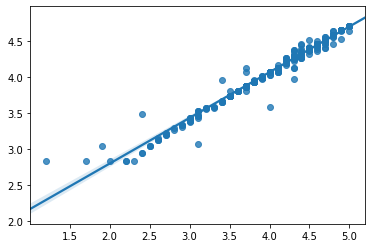

In [168]:
sns.regplot(x=train['rating_yandex'].as_data_frame().values.flatten(), y=m.predict(train).as_data_frame().values.flatten())

gbm prediction progress: |████████████████████████████████████████████████| 100%


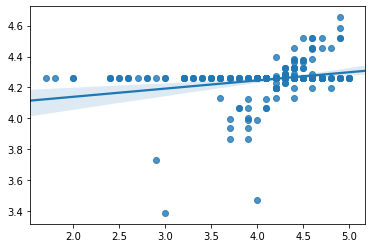

In [169]:
sns.regplot(x=test['rating_yandex'].as_data_frame().values.flatten(), y=m.predict(test).as_data_frame().values.flatten())

In [0]:
y_true = fr['rating_yandex'].as_data_frame()

In [129]:
from scipy.stats import boxcox
boxcox(y_true.values.flatten())

(array([143.84086498, 128.99388341, 177.49986747, ..., 239.12730043,
        159.98322138, 177.49986747]), 4.513554039003673)

In [132]:
box = boxcox(y_true.values.flatten())
box[0]

array([143.84086498, 128.99388341, 177.49986747, ..., 239.12730043,
       159.98322138, 177.49986747])

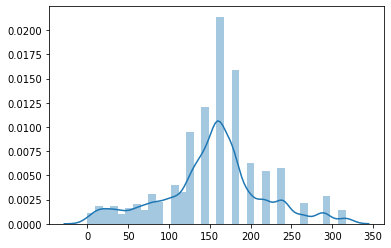

In [133]:
sns.distplot(box[0])

In [0]:
df['rating_yandex'] = boxcox(df['rating_yandex'])[0]

In [0]:
df.reset_index(inplace=True)

In [0]:
#формула гаверсинусов
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [0]:
dots = df[['lat','lng']].dropna()

In [0]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, atan2, sqrt
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor


In [0]:
knc = NearestNeighbors(metric=distance).fit(X=dots)

In [0]:
distances, indexes = knc.kneighbors(X=dots, n_neighbors=6,)

In [0]:
center_coords = (30.26417, 59.89444)

In [0]:
c_dist = pd.DataFrame(df.apply(lambda x: distance(x[['lat', 'lng']], center_coords), axis = 1 ))

In [0]:
c_dist.columns = ['dist_to_center']

In [236]:
c_dist.head()

,dist_to_center,distance_1,distance_2,distance_3,distance_4,distance_5
0,3973.552972,0.0,0.147547,0.900955,0.900955,0.900955
1,3965.207212,0.0,0.247184,0.277490,0.277490,0.346255
2,3965.207212,0.0,0.247184,0.277490,0.277490,0.346255
3,3966.880625,0.0,0.000000,0.000000,0.119962,0.200271
4,3966.880625,0.0,0.000000,0.000000,0.119962,0.200271


In [0]:
c_dist[]

In [0]:
#лучший результат для 4-5 точек
for i in range(1,6):
    c_dist['distance_%s'%i] = distances[:,i]
    #c_dist['indexes_%s'%i] = indexes[:,i]

In [0]:
temp = pd.concat([c_dist, df], axis=1)

In [238]:
temp.head()

,dist_to_center,distance_1,distance_2,distance_3,distance_4,distance_5,lat,lng,name,rating_yandex,review_count,reviews,discount_10,discount_15,discount_20,discount_50,discount_7,Завтраки в ресторане МА,Счастливые часы,барная стойка,бесплатная парковка,бранчи,винная карта,детская анимация,живая музыка,закрытие под банкет,круглосуточная кухня,кулинария,кухня_авторская,кухня_азербайджанская,кухня_азиатская,кухня_американская,кухня_английская,кухня_армянская,кухня_белорусская,кухня_веганская,кухня_вегетарианская,кухня_восточная,кухня_греческая,кухня_грузинская,кухня_домашняя,кухня_еврейская,кухня_европейская,кухня_индийская,кухня_индонезийская,кухня_ирландская,кухня_испанская,кухня_итальянская,кухня_кавказская,кухня_китайская,кухня_континентальная,кухня_корейская,кухня_латиноамериканская,кухня_международная,кухня_мексиканская,кухня_морская,кухня_мясная,кухня_национальная,кухня_немецкая,кухня_неткухня_специализации,кухня_паназиатская,кухня_русская,кухня_рыбная,кухня_сербская,кухня_скандинавская,кухня_смешанная,кухня_средиземноморская,кухня_тайская,кухня_узбекская,кухня_украинская,кухня_французская,кухня_фьюжн,кухня_чешская,кухня_шашлык,кухня_японская,меню на английском,местоположение у воды,настольные игры,своя пекарня,танцпол
0,3973.552972,0.0,0.147547,0.900955,0.900955,0.900955,60.041867,30.340230,Кафе-бар Белые ночи,4.2,28.0,"Забегаловка . Но вечером может быть весело|Хорошая кафешка, рядом ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3965.207212,0.0,0.247184,0.277490,0.277490,0.346255,59.927757,30.332271,White Night Music Joint,4.1,105.0,"Хорошая кухня, адекватные цены, джаз. Но интерьер и рассадка остав...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3965.207212,0.0,0.247184,0.277490,0.277490,0.346255,59.927757,30.332271,Kiosk59,4.4,69.0,"Ещё одна кофейня, которую нужно посетить любителям кофе, Здесь Вас...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3966.880625,0.0,0.000000,0.000000,0.119962,0.200271,59.922792,30.282002,Французский дворик,2.7,8.0,"Бар-кафе при гостинице КРАСНЫЕ ЗВЕЗДЫ. Вежливые девочки, но конски...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3966.880625,0.0,0.000000,0.000000,0.119962,0.200271,59.922792,30.282002,Beer House Staff,4.3,135.0,"Мой отзыв от 12.04.19\r\r\n""Обслуживание так себе. Очень долгое. 1...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df =df.drop(columns = ['distance_1'])

In [249]:
df.columns

Index(['dist_to_center', 'distance_2', 'distance_3', 'distance_4',
       'distance_5', 'lat', 'lng', 'name', 'rating_yandex', 'review_count',
       'reviews', 'discount_10', 'discount_15', 'discount_20', 'discount_50',
       'discount_7', 'Завтраки в ресторане МА', 'Счастливые часы',
       'барная стойка', 'бесплатная парковка', 'бранчи', 'винная карта',
       'детская анимация', 'живая музыка', 'закрытие под банкет',
       'круглосуточная кухня', 'кулинария', 'кухня_авторская',
       'кухня_азербайджанская', 'кухня_азиатская', 'кухня_американская',
       'кухня_английская', 'кухня_армянская', 'кухня_белорусская',
       'кухня_веганская', 'кухня_вегетарианская', 'кухня_восточная',
       'кухня_греческая', 'кухня_грузинская', 'кухня_домашняя',
       'кухня_еврейская', 'кухня_европейская', 'кухня_индийская',
       'кухня_индонезийская', 'кухня_ирландская', 'кухня_испанская',
       'кухня_итальянская', 'кухня_кавказская', 'кухня_китайская',
       'кухня_континентальная', 'ку

In [0]:
df.to_csv(path+'data/temp.csv')

In [251]:
fr = h2o.import_file(path=path+'data/temp.csv')   # import prostate data
fr.names

Parse progress: |█████████████████████████████████████████████████████████| 100%


['C1',
 'dist_to_center',
 'distance_2',
 'distance_3',
 'distance_4',
 'distance_5',
 'lat',
 'lng',
 'name',
 'rating_yandex',
 'review_count',
 'reviews',
 'discount_10',
 'discount_15',
 'discount_20',
 'discount_50',
 'discount_7',
 'Завтраки в ресторане МА',
 'Счастливые часы',
 'барная стойка',
 'бесплатная парковка',
 'бранчи',
 'винная карта',
 'детская анимация',
 'живая музыка',
 'закрытие под банкет',
 'круглосуточная кухня',
 'кулинария',
 'кухня_авторская',
 'кухня_азербайджанская',
 'кухня_азиатская',
 'кухня_американская',
 'кухня_английская',
 'кухня_армянская',
 'кухня_белорусская',
 'кухня_веганская',
 'кухня_вегетарианская',
 'кухня_восточная',
 'кухня_греческая',
 'кухня_грузинская',
 'кухня_домашняя',
 'кухня_еврейская',
 'кухня_европейская',
 'кухня_индийская',
 'кухня_индонезийская',
 'кухня_ирландская',
 'кухня_испанская',
 'кухня_итальянская',
 'кухня_кавказская',
 'кухня_китайская',
 'кухня_континентальная',
 'кухня_корейская',
 'кухня_латиноамериканская',
 '

In [256]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # import gbm estimator

m = H2OGradientBoostingEstimator(ntrees=10, max_depth=5, nfolds = 5, seed = 42)     # setup the gbm

r = fr[0].runif()                       # generate a random vector for splitting

train = fr[ r < 0.7 ]                   # split out 60% for training

test = fr[ 0.7 <= r ]               

m.train(x=fr.names[1:5]+fr.names[12:], y="rating_yandex", training_frame=train \
        )      # train the model

print(m.type)          

gbm Model Build progress: |███████████████████████████████████████████████| 100%
regressor


In [248]:
fr.names

['C1',
 'dist_to_center',
 'distance_2',
 'distance_3',
 'distance_4',
 'distance_5',
 'lat',
 'lng',
 'name',
 'rating_yandex',
 'review_count',
 'reviews',
 'discount_10',
 'discount_15',
 'discount_20',
 'discount_50',
 'discount_7',
 'Завтраки в ресторане МА',
 'Счастливые часы',
 'барная стойка',
 'бесплатная парковка',
 'бранчи',
 'винная карта',
 'детская анимация',
 'живая музыка',
 'закрытие под банкет',
 'круглосуточная кухня',
 'кулинария',
 'кухня_авторская',
 'кухня_азербайджанская',
 'кухня_азиатская',
 'кухня_американская',
 'кухня_английская',
 'кухня_армянская',
 'кухня_белорусская',
 'кухня_веганская',
 'кухня_вегетарианская',
 'кухня_восточная',
 'кухня_греческая',
 'кухня_грузинская',
 'кухня_домашняя',
 'кухня_еврейская',
 'кухня_европейская',
 'кухня_индийская',
 'кухня_индонезийская',
 'кухня_ирландская',
 'кухня_испанская',
 'кухня_итальянская',
 'кухня_кавказская',
 'кухня_китайская',
 'кухня_континентальная',
 'кухня_корейская',
 'кухня_латиноамериканская',
 '

In [253]:
m.r2


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1572783297559_13


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,10.0,2317.0,5.0,5.0,5.0,11.0,19.0,13.9




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.22748224472810638
RMSE: 0.47695098776300526
MAE: 0.3137367700664063
RMSLE: 0.10628871903510434
Mean Residual Deviance: 0.22748224472810638

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.26364459544220986
RMSE: 0.5134633340777215
MAE: 0.33817430481862193
RMSLE: 0.11329424577809924
Mean Residual Deviance: 0.26364459544220986

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.33762005,0.04429722,0.33035797,0.37713933,0.31684786,0.38543606,0.27831906
1,mean_residual_deviance,0.26256335,0.08154203,0.24320804,0.3390953,0.19824147,0.35614103,0.17613095
2,mse,0.26256335,0.08154203,0.24320804,0.3390953,0.19824147,0.35614103,0.17613095
3,r2,-0.027287824,0.03776472,-0.0061449283,-0.02200098,-0.08738885,-0.033372827,0.012468466
4,residual_deviance,0.26256335,0.08154203,0.24320804,0.3390953,0.19824147,0.35614103,0.17613095
5,rmse,0.5074357,0.07962711,0.49316126,0.5823189,0.44524315,0.59677553,0.41967958
6,rmsle,0.11135664,0.021563828,0.10777314,0.13028061,0.09180529,0.13689193,0.090032235



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2019-11-03 14:58:57,1.253 sec,0.0,0.508663,0.333185,0.258738
1,,2019-11-03 14:58:57,1.269 sec,1.0,0.503790,0.329869,0.253804
2,,2019-11-03 14:58:57,1.282 sec,2.0,0.499767,0.327498,0.249767
3,,2019-11-03 14:58:57,1.300 sec,3.0,0.495257,0.324318,0.245279
4,,2019-11-03 14:58:57,1.313 sec,4.0,0.491697,0.322352,0.241766
5,,2019-11-03 14:58:57,1.331 sec,5.0,0.488950,0.320875,0.239072
6,,2019-11-03 14:58:57,1.345 sec,6.0,0.485147,0.318615,0.235368
7,,2019-11-03 14:58:57,1.357 sec,7.0,0.482197,0.316997,0.232514
8,,2019-11-03 14:58:57,1.367 sec,8.0,0.480255,0.315832,0.230644
9,,2019-11-03 14:58:57,1.382 sec,9.0,0.478390,0.314816,0.228857



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,lat,52.626740,1.000000,0.433372
1,dist_to_center,22.061449,0.419206,0.181672
2,distance_3,17.808716,0.338397,0.146652
3,distance_4,7.274281,0.138224,0.059902
4,distance_5,6.392395,0.121467,0.052640
5,distance_2,4.972983,0.094495,0.040952
6,discount_20,2.194436,0.041698,0.018071
7,кухня_грузинская,2.035823,0.038684,0.016765
8,кухня_американская,1.420938,0.027000,0.011701
9,кухня_китайская,1.123335,0.021345,0.009250



See the whole table with table.as_data_frame()


<bound method ModelBase.r2 of >

gbm prediction progress: |████████████████████████████████████████████████| 100%


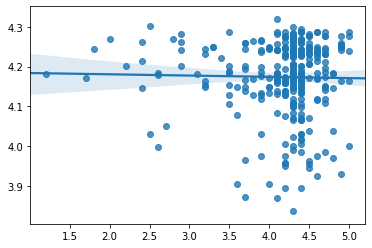

In [257]:
sns.regplot(x=test['rating_yandex'].as_data_frame().values.flatten(), y=m.predict(test).as_data_frame().values.flatten())

gbm prediction progress: |████████████████████████████████████████████████| 100%


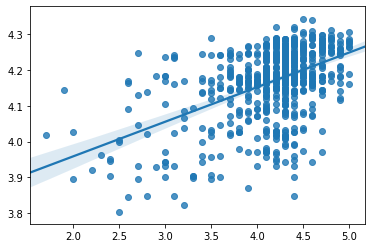

In [258]:
sns.regplot(x=train['rating_yandex'].as_data_frame().values.flatten(), y=m.predict(train).as_data_frame().values.flatten())

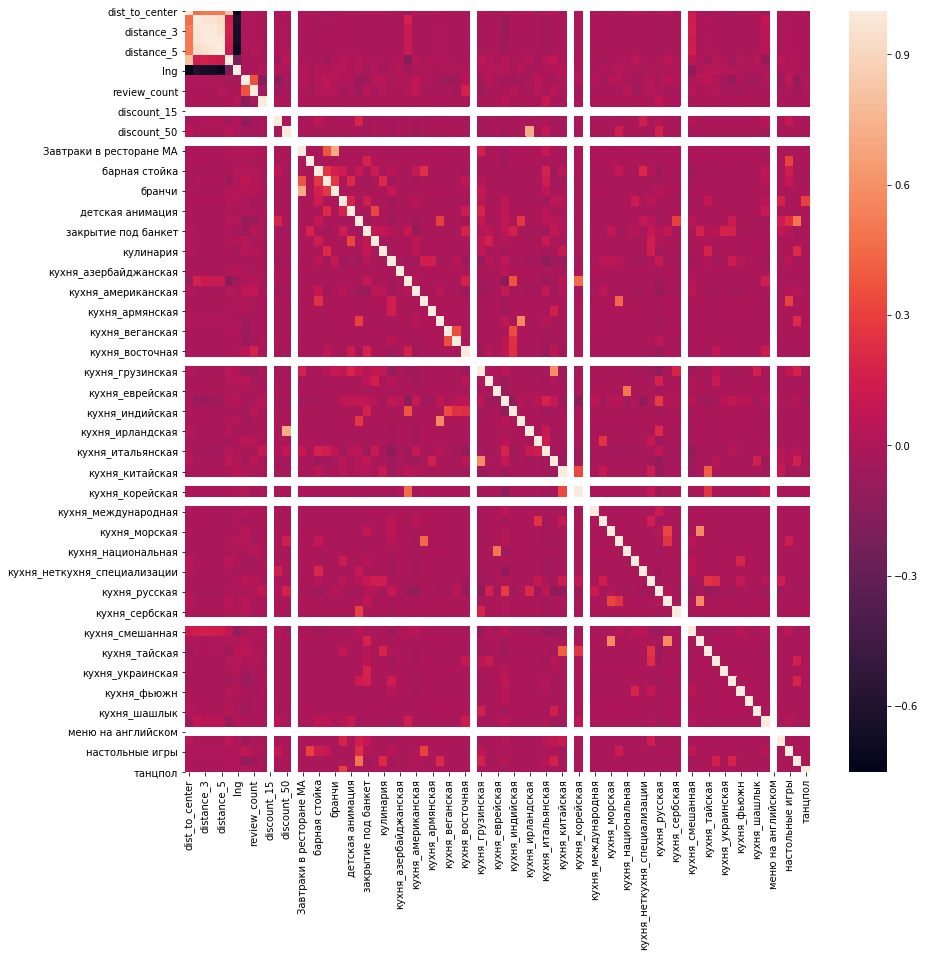

In [259]:
plt.rcParams['figure.figsize']=(14,14)
sns.heatmap(df.corr())

In [0]:
cat_params = {'loss_function': 'RMSE', 'bootstrap_type': 'Poisson', 'subsample': 0.8, "task_type" : 'GPU',
              'verbose': 0, 'depth': 13, 'iterations': 323, 'learning_rate': 0.08076600634041904}

In [0]:
cat = CatBoostRegressor(**cat_params, random_state=42)

In [0]:
label = df['rating_yandex']

In [0]:
label = boxcox(label)[0]

In [0]:
df = df.drop(columns = ['rating_yandex'])

In [269]:
df.shape

(1067, 76)

In [0]:
df = df.drop(columns = ['name', 'reviews'])

In [0]:
df = df.fillna(0)

In [0]:
 cols  = [ i for i in range(7,75)]

In [0]:
df[df.columns[cols]] = df[df.columns[cols]].astype(int)

In [0]:
# initialize Pool
from catboost import Pool, CatBoostRegressor, cv
from sklearn.model_selection import train_test_split
train, test, train_label, test_label = train_test_split(
     df, label,  test_size=0.3, random_state=42)


train_pool = Pool(train, 
                  train_label, 
                  cat_features=cols)
test_pool = Pool(test, 
                 cat_features=cols) 

params = {  
    'iterations':200, 
    'depth':8, 
    'learning_rate' : 0.1, 
    'subsample' : 0.8,
    'loss_function' : 'RMSE', 'verbose':0
    
}
# specify the training parameters 
model = CatBoostRegressor(**params)
#train the model
#cv(train_pool, params)
# make the prediction using the resulting model
model.fit(train_pool)
preds = model.predict(test_pool)
#print(preds)

In [0]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def get_score(y_true, y_pred):
  return dict(
    corr=np.corrcoef(y_true, y_pred)[0][1],
    rmse=mean_squared_error(y_true, y_pred)**0.5,
    r2=r2_score(y_true, y_pred))

In [306]:
get_score(test_label, preds)

{'corr': 0.4271190737943979,
 'r2': 0.13862293883863475,
 'rmse': 55.281609963939765}

In [0]:
cat_params = {'loss_function': 'RMSE', 'bootstrap_type': 'Poisson', 'subsample': 0.8, "task_type" : 'GPU',
              'verbose': 0, 'depth': 13, 'iterations': 323, 'learning_rate': 0.08076600634041904}

In [0]:
from sklearn.metrics import 

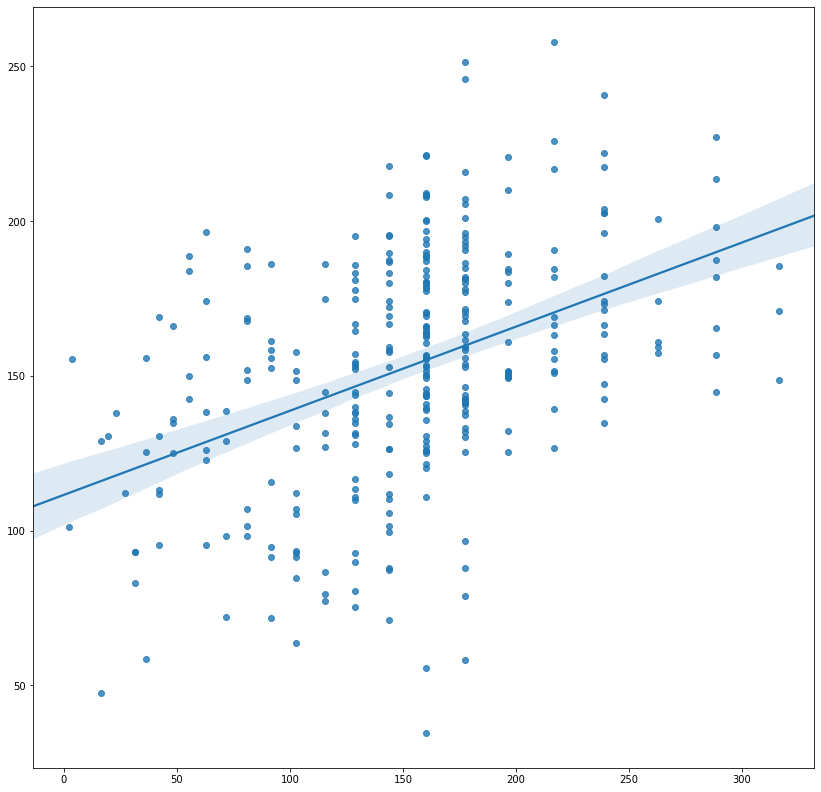

In [301]:
sns.regplot(x=test_label, y=preds)